In [1]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import cv2

import os

def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

camper_data = read_json("/opt/ml/input/data/ICDAR17_Korean/ufo/annotation.json")  # FIXME

# https://pandas.pydata.org/docs/user_guide/merging.html?highlight=group#concatenating-objects
image_names = []
words_dfs = []
for key, value in camper_data['images'].items():
    image_names.append(key)
    words_dfs.append(pd.DataFrame(value['words']).T)

df = pd.concat(words_dfs, keys=image_names)

# https://pandas.pydata.org/docs/user_guide/advanced.html
df['image_name'] = df.index.get_level_values(0)
df['points_id'] = df.index.get_level_values(1).astype(int)
df.index = (_ for _ in range(len(df)))

legible_df = df.loc[df.illegibility == False] # illegible한 points는 무시합니다.
illegible_df = df.loc[df.illegibility == True] # illegible한 points만 변경합니다.

df

,points,orientation,transcription,word_tags,language,illegibility,image_name,points_id
0,"[[67.5, 356.67], [802.5, 356.67], [802.5, 520....",Horizontal,MAGNUM,[blur],[EN],False,14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG,0
1,"[[822.5, 381.67], [962.5, 381.67], [962.5, 520...",Horizontal,IN,[blur],[EN],False,14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG,1
2,"[[987.5, 398.33], [1339.17, 398.33], [1339.17,...",Horizontal,PARIS,None,[EN],False,14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG,2
3,"[[190.83, 853.33], [510.83, 798.33], [529.17, ...",Horizontal,매그넘,None,[KO],False,14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG,3
4,"[[527.5, 798.33], [542.5, 888.33], [649.17, 87...",Horizontal,인,None,[KO],False,14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG,4
...,...,...,...,...,...,...,...,...
30660,"[[951.0, 3419.25], [1051, 3419.25], [1051, 350...",Horizontal,425,None,[Others],False,IMG_5464.jpeg,33
30661,"[[1088.5, 3419.25], [1098.5, 3419.25], [1098.5...",Horizontal,),None,[Others],False,IMG_5464.jpeg,34
30662,"[[938.5, 3424.25], [951.0, 3424.25], [951.0, 3...",Horizontal,(,None,[Others],False,IMG_5464.jpeg,35
30663,"[[618.0, 3132.33], [661.33, 3132.33], [661.33,...",Horizontal,D,None,[EN],False,IMG_5464.jpeg,36


Text(0.5, 1.0, '# of pts: 184; 20210314_151949.jpg')

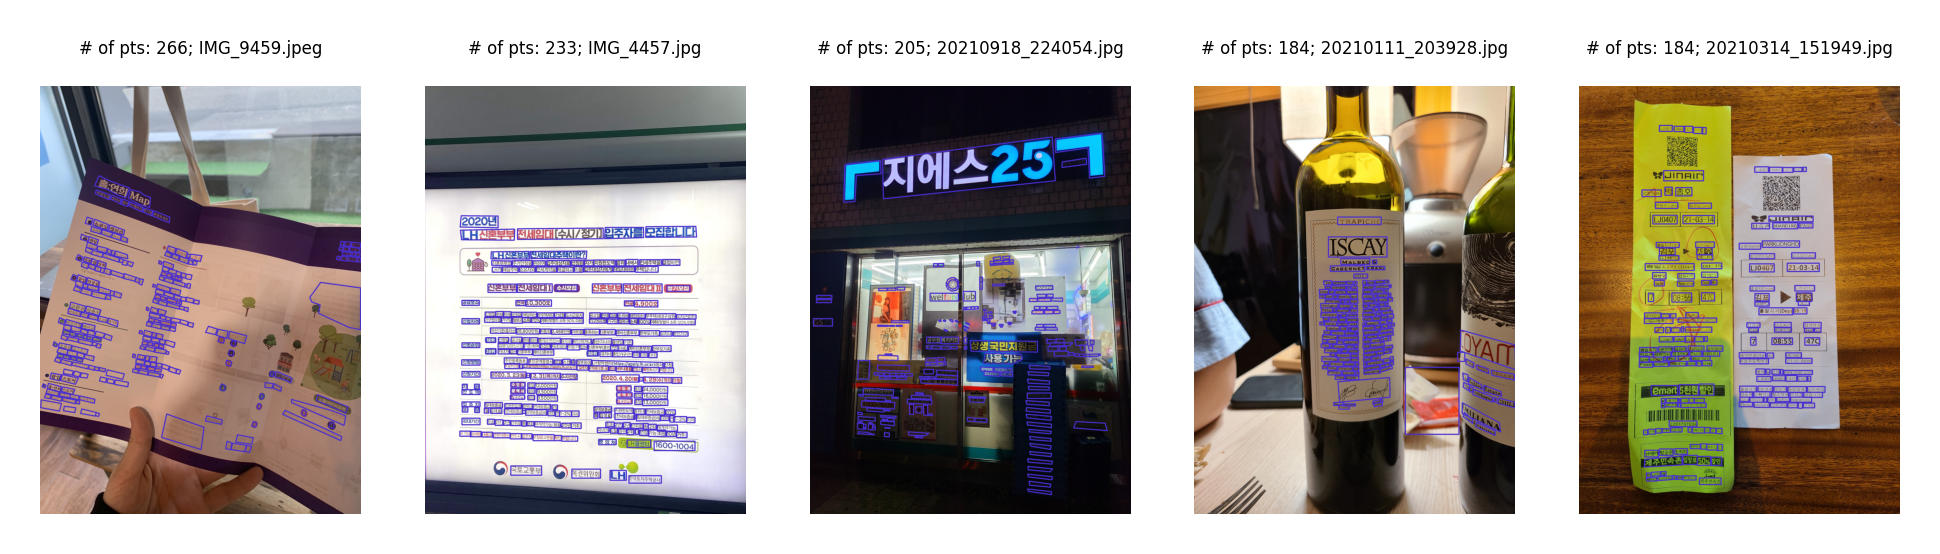

In [2]:
def plot_polyBoxes(_ax, image_name, image_dir_path='/opt/ml/input/data/ICDAR17_Korean/dataset_2'):
    image_path = f"{image_dir_path}/{image_name}"
    assert Path(image_dir_path).exists(), "이미지 dir 경로를 확인하세요."
    assert Path(image_path).exists(), "이미지 파일명을 확인하세요."
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    anns = df.loc[df.image_name == image_name, 'points']
    
    # 황인재_T2247 캠퍼님 글 참조.
    for ann in anns:
        img = cv2.polylines(img, np.array([ann], dtype=np.int32), True, (73,46,207), 10)
    _ax.imshow(img)
    _ax.axis('off')

fig, axes = plt.subplots(1, 5, dpi=400)
plot_polyBoxes(axes[0], 'IMG_9459.jpeg')
axes[0].set_title('# of pts: 266; IMG_9459.jpeg', size=3)
plot_polyBoxes(axes[1], 'IMG_4457.jpg')
axes[1].set_title('# of pts: 233; IMG_4457.jpg', size=3)
plot_polyBoxes(axes[2], '20210918_224054.jpg')
axes[2].set_title('# of pts: 205; 20210918_224054.jpg', size=3)
plot_polyBoxes(axes[3], '20210111_203928.jpg')
axes[3].set_title('# of pts: 184; 20210111_203928.jpg', size=3)
plot_polyBoxes(axes[4], '20210314_151949.jpg')
axes[4].set_title('# of pts: 184; 20210314_151949.jpg', size=3)

In [3]:
def chk_space_in_word(word):
    if word:
        for spell in word:
            if spell in [' ']:
                return True
    return False

def chk_neg_points(points):
    for x, y in points:
        if x < 0:
            return True
        elif y < 0:
            return True
    return False

#   image에 points가 아예 없는 경우
_df = pd.DataFrame(camper_data['images']).T
empty_image = set(_df.loc[_df.words == {}].index)

#   points는 있지만 text가 없는 경우
empty_transcription_image = legible_df.loc[legible_df.transcription.apply(len) == 0, 'image_name']
empty_transcription_image = set(empty_transcription_image)

#   points의 좌표 개수가 홀수인 경우
odd_points_image = df.loc[df.points.apply(len) % 2 != 0, 'image_name']
odd_points_image = set(odd_points_image)

#   text 내에 공백이 포함된 경우
has_space_iamge = df.loc[df.transcription.apply(chk_space_in_word), 'image_name']
has_space_iamge = set(has_space_iamge)

#   points의 좌표 중 -값을 가지는 경우
neg_potins_image = df.loc[df.points.apply(chk_neg_points), 'image_name']
neg_potins_image = set(neg_potins_image)

#   points의 좌표 개수가 4 초과인 경우 (Polygon)
poly_points_image = df.loc[df.points.apply(len) > 4, 'image_name']
poly_points_image = set(poly_points_image)

#  points의 개수가 4개 미만인 경우
less_poly_points_image = df.loc[df.points.apply(len) < 4, 'image_name']
less_poly_points_image = set(less_poly_points_image)

# 모든 case들을 고려한 경우
noisy_image = empty_transcription_image | odd_points_image
noisy_image |= has_space_iamge
noisy_image |= neg_potins_image
noisy_image |= empty_image
noisy_image |= less_poly_points_image # 4개보다 적은 경우
# noisy_image |= poly_points_image # 4개 초과 >> 쓸거

In [4]:
len(less_poly_points_image)

34

In [5]:
len(poly_points_image)

374

In [7]:
path = '/opt/ml/input/data/ICDAR17_Korean/dataset_2'
len(os.listdir(path))

1651

In [8]:
path = '../input/data/ICDAR17_Korean/images'
len(set(os.listdir(path)))

537

In [9]:
len(set(os.listdir(path))-noisy_image)

537

In [5]:
# 캠퍼 데이터 annotation 읽어오기
camper_data_path = '/opt/ml/input/data/ICDAR17_Korean/ufo/annotation.json'
with open(camper_data_path, 'r') as f:
    new_image_anno = json.load(f)

# 노이즈 제거
# for i in noisy_image:
#     del(new_image_anno['images'][i])

In [6]:
len(new_image_anno['images'])

1650

In [8]:
# copy camper_data > new_data
import shutil

origin_path = '/opt/ml/input/data/ICDAR17_Korean/dataset_2'
new_path = '../input/data/new_images/images'

for image in new_image_anno['images']:
    origin_dir = os.path.join(origin_path, image)
    new_dir = os.path.join(new_path, image)
    shutil.copyfile(origin_dir, new_dir)    

In [9]:
# 원본 데이터 annotation 읽어오기
images_path = '../input/data/ICDAR17_Korean/ufo/train.json'
with open(images_path, 'r') as f:
    origin_image_anno = json.load(f)

In [10]:
len(origin_image_anno['images'])

536

In [11]:
# copy images > new_data
origin_path = '../input/data/ICDAR17_Korean/images'
new_path = '../input/data/new_images/images'

for image in origin_image_anno['images']:
    origin_dir = os.path.join(origin_path, image)
    new_dir = os.path.join(new_path, image)
    shutil.copyfile(origin_dir, new_dir)

In [13]:
# annotaion 합쳐주기
new_image_anno['images'].update(origin_image_anno['images'])

output_path = '../input/data/new_images/ufo/train.json'
with open(output_path, 'w') as f:
    json.dump(new_image_anno, f, indent = 4)

In [14]:
path = '../input/data/new_data/images'
len(set(os.listdir(path)))

2186

In [15]:
len(new_image_anno['images'])

2186

In [17]:
# 원본 데이터 annotation 읽어오기
output_path = '../input/data/new_data/ufo/train.json'
with open(output_path, 'r') as f:
    tttt = json.load(f)
len(tttt['images'])

2186

In [ ]:
# copy camper_data > new_data
import shutil

origin_path = '/opt/ml/input/data/ICDAR17_Korean/dataset_2' #새로운 데이터
new_path = '../input/data/new_data/images'   

for image in new_image_anno['images']:
    origin_dir = os.path.join(origin_path, image)
    new_dir = os.path.join(new_path, image)
    shutil.copyfile(origin_dir, new_dir)    